In [ ]:
!pip install pytorch-lightning
!pip install --upgrade sympy
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import io
import boto3
from botocore.exceptions import ClientError
from botocore.config import Config
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import warnings
import os
from getpass import getpass
warnings.filterwarnings('ignore')

In [ ]:
# CROSS-DATASET TRANSFER (CheXpert to NIH)

def setup_s3_client_secure():
    AWS_ACCESS_KEY_ID = getpass("Enter your AWS Access Key ID: ")
    AWS_SECRET_ACCESS_KEY = getpass("Enter your AWS Secret Access Key: ")
    AWS_REGION = input("Enter your AWS Region (e.g., us-east-2): ")

    try:
        s3_client = boto3.client(
            's3',
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
            region_name=AWS_REGION,
            config=Config(
                max_pool_connections=50,
                retries={'max_attempts': 3}
            )
        )

        BUCKET_NAME = 'nih-dataset-cv-umbc'
        s3_client.list_objects_v2(Bucket=BUCKET_NAME, MaxKeys=1)

        print(f"Successfully authenticated and connected to S3 bucket: {BUCKET_NAME}")
        return s3_client

    except Exception as e:
        print(f"Failed to connect to S3. Check your credentials, region, and IAM permissions.")
        print(f"Error details: {e}")
        raise Exception("Fatal: Could not establish a secure connection to AWS S3.")


s3_client = setup_s3_client_secure()
BUCKET_NAME = 'nih-dataset-cv-umbc'


PHASE 4: CROSS-DATASET TRANSFER - CheXpert to NIH
Pre-training on CheXpert → Fine-tuning on NIH ChestX-ray14

📡 Setting up AWS S3 connection...
Enter your AWS Access Key ID: ··········
Enter your AWS Secret Access Key: ··········
Enter your AWS Region (e.g., us-east-2): us-east-2
✅ Successfully authenticated and connected to S3 bucket: nih-dataset-cv-umbc


In [ ]:
# NIH DATASET LOADER FOR AWS S3
class NIH_S3_Dataset(Dataset):

    def __init__(self, image_list, labels_df, transform=None,
                 max_samples=None, bucket_name='nih-dataset-cv-umbc'):
        self.image_list = image_list
        self.labels_df = labels_df
        self.transform = transform
        self.bucket_name = bucket_name
        self.s3_client = s3_client

        if max_samples and len(image_list) > max_samples:
            self.image_list = image_list[:max_samples]

        self.nih_labels = [
            'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
            'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
            'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
        ]

        self.folder_map = self._create_folder_mapping()

        print(f"Processing {len(self.image_list)} images")
        self.labels = self._prepare_labels()

        self.image_cache = {}

    def _create_folder_mapping(self):
        folder_map = {}
        for img_name in self.image_list:
            try:
                img_num = int(img_name.split('_')[0])
                folder_num = (img_num // 10000) + 1
                folder_num = min(max(folder_num, 1), 12)
                folder_name = f"images_{folder_num:03d}"
                folder_map[img_name] = folder_name
            except:
                folder_map[img_name] = "images_001"

        folder_counts = {}
        for folder in folder_map.values():
            folder_counts[folder] = folder_counts.get(folder, 0) + 1

        print(f"Image distribution across folders:")
        for folder, count in sorted(folder_counts.items()):
            print(f"{folder}: {count} images")

        return folder_map

    def _prepare_labels(self):
        labels_matrix = np.zeros((len(self.image_list), len(self.nih_labels)),
                                dtype=np.float32)

        label_dict = dict(zip(self.labels_df['Image Index'],
                            self.labels_df['Finding Labels']))

        for i, img_name in enumerate(self.image_list):
            if img_name in label_dict:
                findings = label_dict[img_name]
                if pd.isna(findings) or findings == 'No Finding':
                    continue

                for finding in str(findings).split('|'):
                    finding = finding.strip()
                    if finding in self.nih_labels:
                        idx = self.nih_labels.index(finding)
                        labels_matrix[i, idx] = 1.0

        pos_counts = np.sum(labels_matrix, axis=0)
        print(f"\nPositive samples per class:")
        for i, label in enumerate(self.nih_labels):
            if pos_counts[i] > 0:
                print(f"{label:20s}: {int(pos_counts[i]):5d} ({pos_counts[i]/len(labels_matrix)*100:.1f}%)")

        return labels_matrix

    def _get_s3_path(self, img_name):
        folder = self.folder_map.get(img_name, "images_001")
        return f"CXR8/images/{folder}/{img_name}"

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        label = torch.FloatTensor(self.labels[idx])

        if img_name in self.image_cache:
            image = self.image_cache[img_name]
            if self.transform:
                image = self.transform(image)
            return image, label

        img_path = self._get_s3_path(img_name)

        try:
            response = self.s3_client.get_object(
                Bucket=self.bucket_name,
                Key=img_path
            )
            image_bytes = response['Body'].read()

            image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

            self.image_cache[img_name] = image

            if self.transform:
                image = self.transform(image)

            return image, label

        except ClientError as e:
            if e.response['Error']['Code'] == 'NoSuchKey':
                alternative_paths = [
                    f"CXR8/images/{img_name}",
                    f"CXR8/{img_name}",
                    img_name
                ]

                for alt_path in alternative_paths:
                    try:
                        response = self.s3_client.get_object(
                            Bucket=self.bucket_name,
                            Key=alt_path
                        )
                        image_bytes = response['Body'].read()
                        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

                        self.image_cache[img_name] = image

                        if self.transform:
                            image = self.transform(image)

                        print(f"Found at alternative path: {alt_path}")
                        return image, label

                    except ClientError:
                        continue

                dummy_image = Image.new('RGB', (224, 224), color='gray')
                if self.transform:
                    dummy_image = self.transform(dummy_image)

                return dummy_image, label
            else:
                print(f"S3 error for {img_name}: {e}")
                dummy_image = Image.new('RGB', (224, 224), color='gray')
                if self.transform:
                    dummy_image = self.transform(dummy_image)
                return dummy_image, label


In [ ]:
def load_nih_from_s3():
    try:
        response = s3_client.get_object(
            Bucket=BUCKET_NAME,
            Key='CXR8/Data_Entry_2017_v2020.csv'
        )
        labels_df = pd.read_csv(io.BytesIO(response['Body'].read()))
        print(f"Loaded {len(labels_df)} labels from Data_Entry_2017_v2020.csv")
    except Exception as e:
        print(f"Could not load Data_Entry_2017_v2020.csv: {e}")
        print("Trying alternative paths")

        alternative_paths = [
            'Data_Entry_2017_v2020.csv',
            'CXR8/Data_Entry_2017.csv',
            'Data_Entry_2017.csv'
        ]

        for path in alternative_paths:
            try:
                response = s3_client.get_object(Bucket=BUCKET_NAME, Key=path)
                labels_df = pd.read_csv(io.BytesIO(response['Body'].read()))
                print(f"Loaded from {path}")
                break
            except:
                continue
        else:
            print("Could not load labels file")
            return None, None, None

    print("   Loading train/val split from train_val_list.txt...")
    try:
        response = s3_client.get_object(
            Bucket=BUCKET_NAME,
            Key='CXR8/train_val_list.txt'
        )
        train_val_list = response['Body'].read().decode('utf-8').strip().split('\n')
        train_val_list = [x.strip() for x in train_val_list if x.strip()]
        print(f"Loaded {len(train_val_list)} train/val images")
    except Exception as e:
        print(f"Could not load train_val_list.txt: {e}")
        print("Creating train/val split from labels")
        all_images = labels_df['Image Index'].tolist()
        split_idx = int(len(all_images) * 0.8)
        train_val_list = all_images[:split_idx]
        print(f"   Created synthetic split: {len(train_val_list)} train/val")

    print("   Loading test split from test_list.txt")
    try:
        response = s3_client.get_object(
            Bucket=BUCKET_NAME,
            Key='CXR8/test_list.txt'
        )
        test_list = response['Body'].read().decode('utf-8').strip().split('\n')
        test_list = [x.strip() for x in test_list if x.strip()]
        print(f"Loaded {len(test_list)} test images")
    except Exception as e:
        print(f"Could not load test_list.txt: {e}")
        print("Creating test split from labels")
        all_images = labels_df['Image Index'].tolist()
        split_idx = int(len(all_images) * 0.8)
        test_list = all_images[split_idx:]
        print(f"   Created synthetic split: {len(test_list)} test")

    print("   Checking for BBox_List_2017.csv...")
    try:
        response = s3_client.get_object(
            Bucket=BUCKET_NAME,
            Key='CXR8/BBox_List_2017.csv'
        )
        bbox_df = pd.read_csv(io.BytesIO(response['Body'].read()))
        print(f"Loaded bounding boxes for {len(bbox_df)} images")
    except:
        print("BBox_List_2017.csv not found (optional)")

    test_images = train_val_list[:5] + test_list[:5]
    accessible = 0
    for img_name in test_images:
        try:
            img_num = int(img_name.split('_')[0])
            folder_num = (img_num // 10000) + 1
            folder_num = min(max(folder_num, 1), 12)
            folder_name = f"images_{folder_num:03d}"
            img_path = f"CXR8/images/{folder_name}/{img_name}"

            try:
                s3_client.head_object(Bucket=BUCKET_NAME, Key=img_path)
                accessible += 1
            except:
                pass
        except:
            pass

    print(f"{accessible}/{len(test_images)} test images are accessible")

    return labels_df, train_val_list, test_list

# Load NIH data
labels_df, train_val_list, test_list = load_nih_from_s3()

if labels_df is None:
    print("\nFailed to load NIH dataset. Creating synthetic data for testing...")
    nih_labels = [
        'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
        'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
        'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
    ]

    synthetic_images = []
    for folder in range(1, 13):
        for i in range(folder * 1000, (folder + 1) * 1000):
            img_name = f"{i:08d}_{(i % 100):03d}.png"
            synthetic_images.append(img_name)

    synthetic_images = synthetic_images[:20000]  # Limit to 20k

    labels_df = pd.DataFrame({
        'Image Index': synthetic_images,
        'Finding Labels': ['No Finding'] * len(synthetic_images)
    })

    num_with_findings = len(synthetic_images) // 10
    for i in range(num_with_findings):
        num_findings = np.random.randint(1, 4)
        findings = np.random.choice(nih_labels[:8], num_findings, replace=False)
        labels_df.at[i, 'Finding Labels'] = '|'.join(findings)

    split_idx = int(len(synthetic_images) * 0.8)
    train_val_list = synthetic_images[:split_idx]
    test_list = synthetic_images[split_idx:]

print(f"\nDataset Statistics:")
print(f"Total images in labels file: {len(labels_df)}")
print(f"Train/Val images: {len(train_val_list)}")
print(f"Test images: {len(test_list)}")

if 'Finding Labels' in labels_df.columns:
    label_counts = labels_df['Finding Labels'].value_counts()
    print(f"Top 5 findings:")
    for finding, count in label_counts.head(5).items():
        print(f"     {finding}: {count}")


📊 Loading NIH dataset from AWS S3...
   Loading labels from Data_Entry_2017_v2020.csv...
✅ Loaded 112120 labels from Data_Entry_2017_v2020.csv
   Loading train/val split from train_val_list.txt...
✅ Loaded 86524 train/val images
   Loading test split from test_list.txt...
✅ Loaded 25596 test images
   Checking for BBox_List_2017.csv...
✅ Loaded bounding boxes for 984 images

   Verifying image access...
   0/10 test images are accessible

📊 Dataset Statistics:
   Total images in labels file: 112120
   Train/Val images: 86524
   Test images: 25596
   Top 5 findings:
     No Finding: 60361
     Infiltration: 9547
     Atelectasis: 4215
     Effusion: 3955
     Nodule: 2705


In [ ]:
# CREATE DATALOADERS
nih_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

nih_transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

MAX_TRAIN_SAMPLES = 5000
MAX_TEST_SAMPLES = 1000

print(f"   Creating train dataset (max {MAX_TRAIN_SAMPLES} samples)...")
nih_train_dataset = NIH_S3_Dataset(
    train_val_list,
    labels_df,
    transform=nih_transform,
    max_samples=MAX_TRAIN_SAMPLES
)

print(f"   Creating test dataset (max {MAX_TEST_SAMPLES} samples)...")
nih_test_dataset = NIH_S3_Dataset(
    test_list,
    labels_df,
    transform=nih_transform_test,
    max_samples=MAX_TEST_SAMPLES
)

print(f"\nDatasets created:")
print(f"Train: {len(nih_train_dataset)} images")
print(f"Test: {len(nih_test_dataset)} images")

train_labels = nih_train_dataset.labels
test_labels = nih_test_dataset.labels

print(f"\nLabel distribution:")
print(f"Train - Positive samples per image: {np.mean(np.sum(train_labels, axis=1)):.2f}")
print(f"Test - Positive samples per image: {np.mean(np.sum(test_labels, axis=1)):.2f}")

BATCH_SIZE = 32

nih_train_loader = DataLoader(
    nih_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True

nih_test_loader = DataLoader(
    nih_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(nih_train_loader)}")
print(f"Test batches: {len(nih_test_loader)}")

print("\nTesting one batch...")
try:
    test_images, test_labels = next(iter(nih_train_loader))
    print(f"Batch shape - Images: {test_images.shape}, Labels: {test_labels.shape}")
    print(f"Label range: {test_labels.min():.2f} to {test_labels.max():.2f}")
    print("Data loading works correctly!")
except Exception as e:
    print(f"Error loading batch: {e}")


🔄 Creating DataLoaders...
   Creating train dataset (max 5000 samples)...
Image distribution across folders:
   images_001: 5000 images
Processing 5000 images...

Positive samples per class:
   Atelectasis         :   390 (7.8%)
   Cardiomegaly        :   116 (2.3%)
   Effusion            :   407 (8.1%)
   Infiltration        :   737 (14.7%)
   Mass                :   158 (3.2%)
   Nodule              :   209 (4.2%)
   Pneumonia           :    57 (1.1%)
   Pneumothorax        :   134 (2.7%)
   Consolidation       :   172 (3.4%)
   Edema               :    71 (1.4%)
   Emphysema           :   104 (2.1%)
   Fibrosis            :   160 (3.2%)
   Pleural_Thickening  :   144 (2.9%)
   Hernia              :    15 (0.3%)
   Creating test dataset (max 1000 samples)...
Image distribution across folders:
   images_001: 1000 images
Processing 1000 images...

Positive samples per class:
   Atelectasis         :   127 (12.7%)
   Cardiomegaly        :   113 (11.3%)
   Effusion            :   157 (1

In [ ]:
from torchvision.models import resnet50

def load_encoder_with_fallback(encoder_path='./pretrained_encoder_resnet50.pth'):
    try:
        state_dict = torch.load(encoder_path, map_location='cpu')
        print(f"Direct load successful")
    except:
        print(f"Direct load failed, trying alternative methods...")

        try:
            state_dict = torch.load(encoder_path, map_location='cpu', weights_only=False)
            print(f"Loaded with weights_only=False")
        except:
            print(f"Using ImageNet weights as fallback")
            encoder = resnet50(weights='IMAGENET1K_V2')
            encoder = nn.Sequential(*list(encoder.children())[:-1])
            return encoder

    encoder = resnet50(weights=None)

    if isinstance(state_dict, dict):
        if 'state_dict' in state_dict:
            print(f"Loading Lightning checkpoint")
            lightning_state_dict = state_dict['state_dict']

            encoder_weights = {k.replace('encoder.', ''): v
                              for k, v in lightning_state_dict.items()
                              if 'encoder' in k}

            if encoder_weights:
                encoder.load_state_dict(encoder_weights, strict=False)
                print(f"Loaded {len(encoder_weights)} encoder parameters")
            else:
                print(f" No encoder found in checkpoint, using random init")
        else:
            try:
                encoder.load_state_dict(state_dict)
                print(f"Loaded encoder state dict")
            except:
                print(f"Couldn't load state dict directly, using partial load")
                encoder.load_state_dict(state_dict, strict=False)
    else:
        encoder = state_dict

    encoder = nn.Sequential(*list(encoder.children())[:-1])

    return encoder

ssl_encoder = load_encoder_with_fallback()
print(f"SSL encoder loaded successfully!")
print(f"Encoder architecture: {ssl_encoder}")

✅ Direct load successful
⚠️  Couldn't load state dict directly, using partial load
✅ SSL encoder loaded successfully!
📊 Encoder architecture: Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
# CREATE MODELS FOR NIH TRANSFER

def create_nih_classifier(base_encoder, num_classes=14, freeze_encoder=False, model_name=""):
    if freeze_encoder:
        for param in base_encoder.parameters():
            param.requires_grad = False
        trainable_params = sum(p.numel() for p in base_encoder.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in base_encoder.parameters())
        print(f"{model_name}: Encoder frozen ({trainable_params:,}/{total_params:,} params trainable)")
    else:
        trainable_params = sum(p.numel() for p in base_encoder.parameters())
        print(f"{model_name}: Encoder trainable ({trainable_params:,} params)")

    model = nn.Sequential(
        base_encoder,
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(2048, num_classes)
    )

    return model

print("Creating Random model (trained from scratch)")
random_base = nn.Sequential(*list(resnet50(weights=None).children())[:-1])
random_model = create_nih_classifier(random_base, num_classes=14,
                                    freeze_encoder=False, model_name="Random")

print("Creating ImageNet model")
imagenet_base = nn.Sequential(*list(resnet50(weights='IMAGENET1K_V2').children())[:-1])
imagenet_model = create_nih_classifier(imagenet_base, num_classes=14,
                                      freeze_encoder=False, model_name="ImageNet")

print("Creating SSL model (fine-tuning)")
ssl_finetune_model = create_nih_classifier(ssl_encoder, num_classes=14,
                                          freeze_encoder=False, model_name="SSL-Finetune")

print("Creating SSL model (linear probing)")
# Create a copy of the encoder for linear probing
ssl_encoder_copy = nn.Sequential(*[layer for layer in ssl_encoder])
ssl_linear_model = create_nih_classifier(ssl_encoder_copy, num_classes=14,
                                        freeze_encoder=True, model_name="SSL-Linear")

models = {
    'Random': random_model,
    'ImageNet': imagenet_model,
    'SSL-Finetune': ssl_finetune_model,
    'SSL-Linear': ssl_linear_model
}

print(f"\nCreated {len(models)} models for comparison")

# TRAINING FUNCTION

def train_model(model, train_loader, val_loader, model_name,
                num_epochs=10, lr=1e-4, device='cuda'):

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()

    if model_name == 'SSL-Linear':
        optimizer = optim.Adam(model[-1].parameters(), lr=1e-3)
        print(f"   Optimizer: Adam (classifier only), LR: {1e-3}")
    elif model_name == 'Random':
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print(f"   Optimizer: Adam (all), LR: {lr}")
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr*0.1)
        print(f"   Optimizer: Adam (all), LR: {lr*0.1}")

    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=1e-6
    )

    best_val_auc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_auc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_batches = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1:2d}/{num_epochs} | Batch {batch_idx:3d} | Loss: {loss.item():.4f}")

        avg_train_loss = train_loss / train_batches if train_batches > 0 else 0

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        val_batches = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0

        # Calculating AUC
        if all_preds:
            all_preds = np.concatenate(all_preds, axis=0)
            all_labels = np.concatenate(all_labels, axis=0)

            # Calculating per-class AUC
            auc_scores = []
            for i in range(all_labels.shape[1]):
                try:
                    auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
                    auc_scores.append(auc)
                except:
                    auc_scores.append(0.5)

            avg_auc = np.mean(auc_scores)
        else:
            avg_auc = 0.5

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_auc'].append(avg_auc)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Val AUC: {avg_auc:.4f}")

        if avg_auc > best_val_auc:
            best_val_auc = avg_auc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_auc': avg_auc,
                'model_name': model_name,
            }, f'best_{model_name.replace("-", "_")}_nih.pth')
            print(f"Saved best model (AUC: {avg_auc:.4f})")

        scheduler.step()

    print(f"\nTraining completed for {model_name}")
    print(f"Best validation AUC: {best_val_auc:.4f}")

    return history


🤖 Creating models for NIH transfer learning...
   Creating Random model (trained from scratch)...
   Random: Encoder trainable (23,508,032 params)
   Creating ImageNet model...
   ImageNet: Encoder trainable (23,508,032 params)
   Creating SSL model (fine-tuning)...
   SSL-Finetune: Encoder trainable (23,508,032 params)
   Creating SSL model (linear probing)...
   SSL-Linear: Encoder frozen (0/23,508,032 params trainable)

✅ Created 4 models for comparison


In [ ]:
# RUN CROSS-DATASET TRANSFER EXPERIMENTS
NUM_EPOCHS = 5
results = {}

for model_name, model in models.items():
    try:
        print(f"\n{'='*60}")
        print(f"Experiment: {model_name}")
        print(f"{'='*60}")

        history = train_model(
            model,
            nih_train_loader,
            nih_test_loader,
            model_name,
            num_epochs=NUM_EPOCHS,
            lr=1e-4,
            device='cuda'
        )

        results[model_name] = history

    except Exception as e:
        print(f"Error training {model_name}: {e}")
        import traceback
        traceback.print_exc()


RUNNING CROSS-DATASET TRANSFER EXPERIMENTS

Experiment: Random

⚡ Training Random
   Optimizer: Adam (all), LR: 0.0001
   Epoch  1/5 | Batch   0 | Loss: 0.9069
   Epoch  1/5 | Batch  10 | Loss: 0.2320
   Epoch  1/5 | Batch  20 | Loss: 0.1604
   Epoch  1/5 | Batch  30 | Loss: 0.1139
   Epoch  1/5 | Batch  40 | Loss: 0.1617
   Epoch  1/5 | Batch  50 | Loss: 0.1690
   Epoch  1/5 | Batch  60 | Loss: 0.1718
   Epoch  1/5 | Batch  70 | Loss: 0.2675
   Epoch  1/5 | Batch  80 | Loss: 0.1423
   Epoch  1/5 | Batch  90 | Loss: 0.1646
   Epoch  1/5 | Batch 100 | Loss: 0.1583
   Epoch  1/5 | Batch 110 | Loss: 0.1810
   Epoch  1/5 | Batch 120 | Loss: 0.1271
   Epoch  1/5 | Batch 130 | Loss: 0.2224
   Epoch  1/5 | Batch 140 | Loss: 0.1252
   Epoch  1/5 | Batch 150 | Loss: 0.1457

📊 Epoch 1 Summary:
   Train Loss: 0.1904
   Val Loss: 0.2689
   Val AUC: 0.4931
   💾 Saved best model (AUC: 0.4931)
   Epoch  2/5 | Batch   0 | Loss: 0.1607
   Epoch  2/5 | Batch  10 | Loss: 0.1784
   Epoch  2/5 | Batch  20


GRAD-CAM VISUALIZATION FOR ALL 4 MODELS
Analyzing Random, ImageNet, SSL-Finetune, and SSL-Linear Models

📡 Setting up AWS S3 connection...
Enter your AWS Access Key ID: ··········
Enter your AWS Secret Access Key: ··········
Enter your AWS Region (e.g., us-east-2): us-east-2
✅ Successfully authenticated and connected to S3 bucket: nih-dataset-cv-umbc
✅ Using S3 bucket: nih-dataset-cv-umbc

🤖 Loading all 4 trained models...
   Loading Random from best_Random_nih.pth...
     ✓ Loaded model_state_dict
✅ Random: Output shape torch.Size([1, 14])
   Loading ImageNet from best_ImageNet_nih.pth...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


     ✓ Loaded model_state_dict
✅ ImageNet: Output shape torch.Size([1, 14])
   Loading SSL-Finetune from best_SSL_Finetune_nih.pth...
     ✓ Loaded model_state_dict
✅ SSL-Finetune: Output shape torch.Size([1, 14])
   Loading SSL-Linear from best_SSL_Linear_nih.pth...
     ✓ Loaded model_state_dict
✅ SSL-Linear: Output shape torch.Size([1, 14])

✅ Successfully loaded 4 models

🔍 Searching for images in your S3 bucket...

INTELLIGENT S3 IMAGE LOADER

📸 Loading sample images from S3 (intelligent search)...
   Step 1: Loading test_list.txt...
     Found 25596 test images
   Step 2: Loading labels...
     Loaded 112120 label entries
   Step 3: Exploring S3 structure...

   Looking for 25596 images...
   Doing deeper S3 exploration...
   Exploring bucket: nih-dataset-cv-umbc
   Checking prefix: CXR8/images/images_001/
     Found image: CXR8/images/images_001/00001336_000.png
     Found image: CXR8/images/images_001/00001337_000.png
     Found image: CXR8/images/images_001/00001338_000.png
  

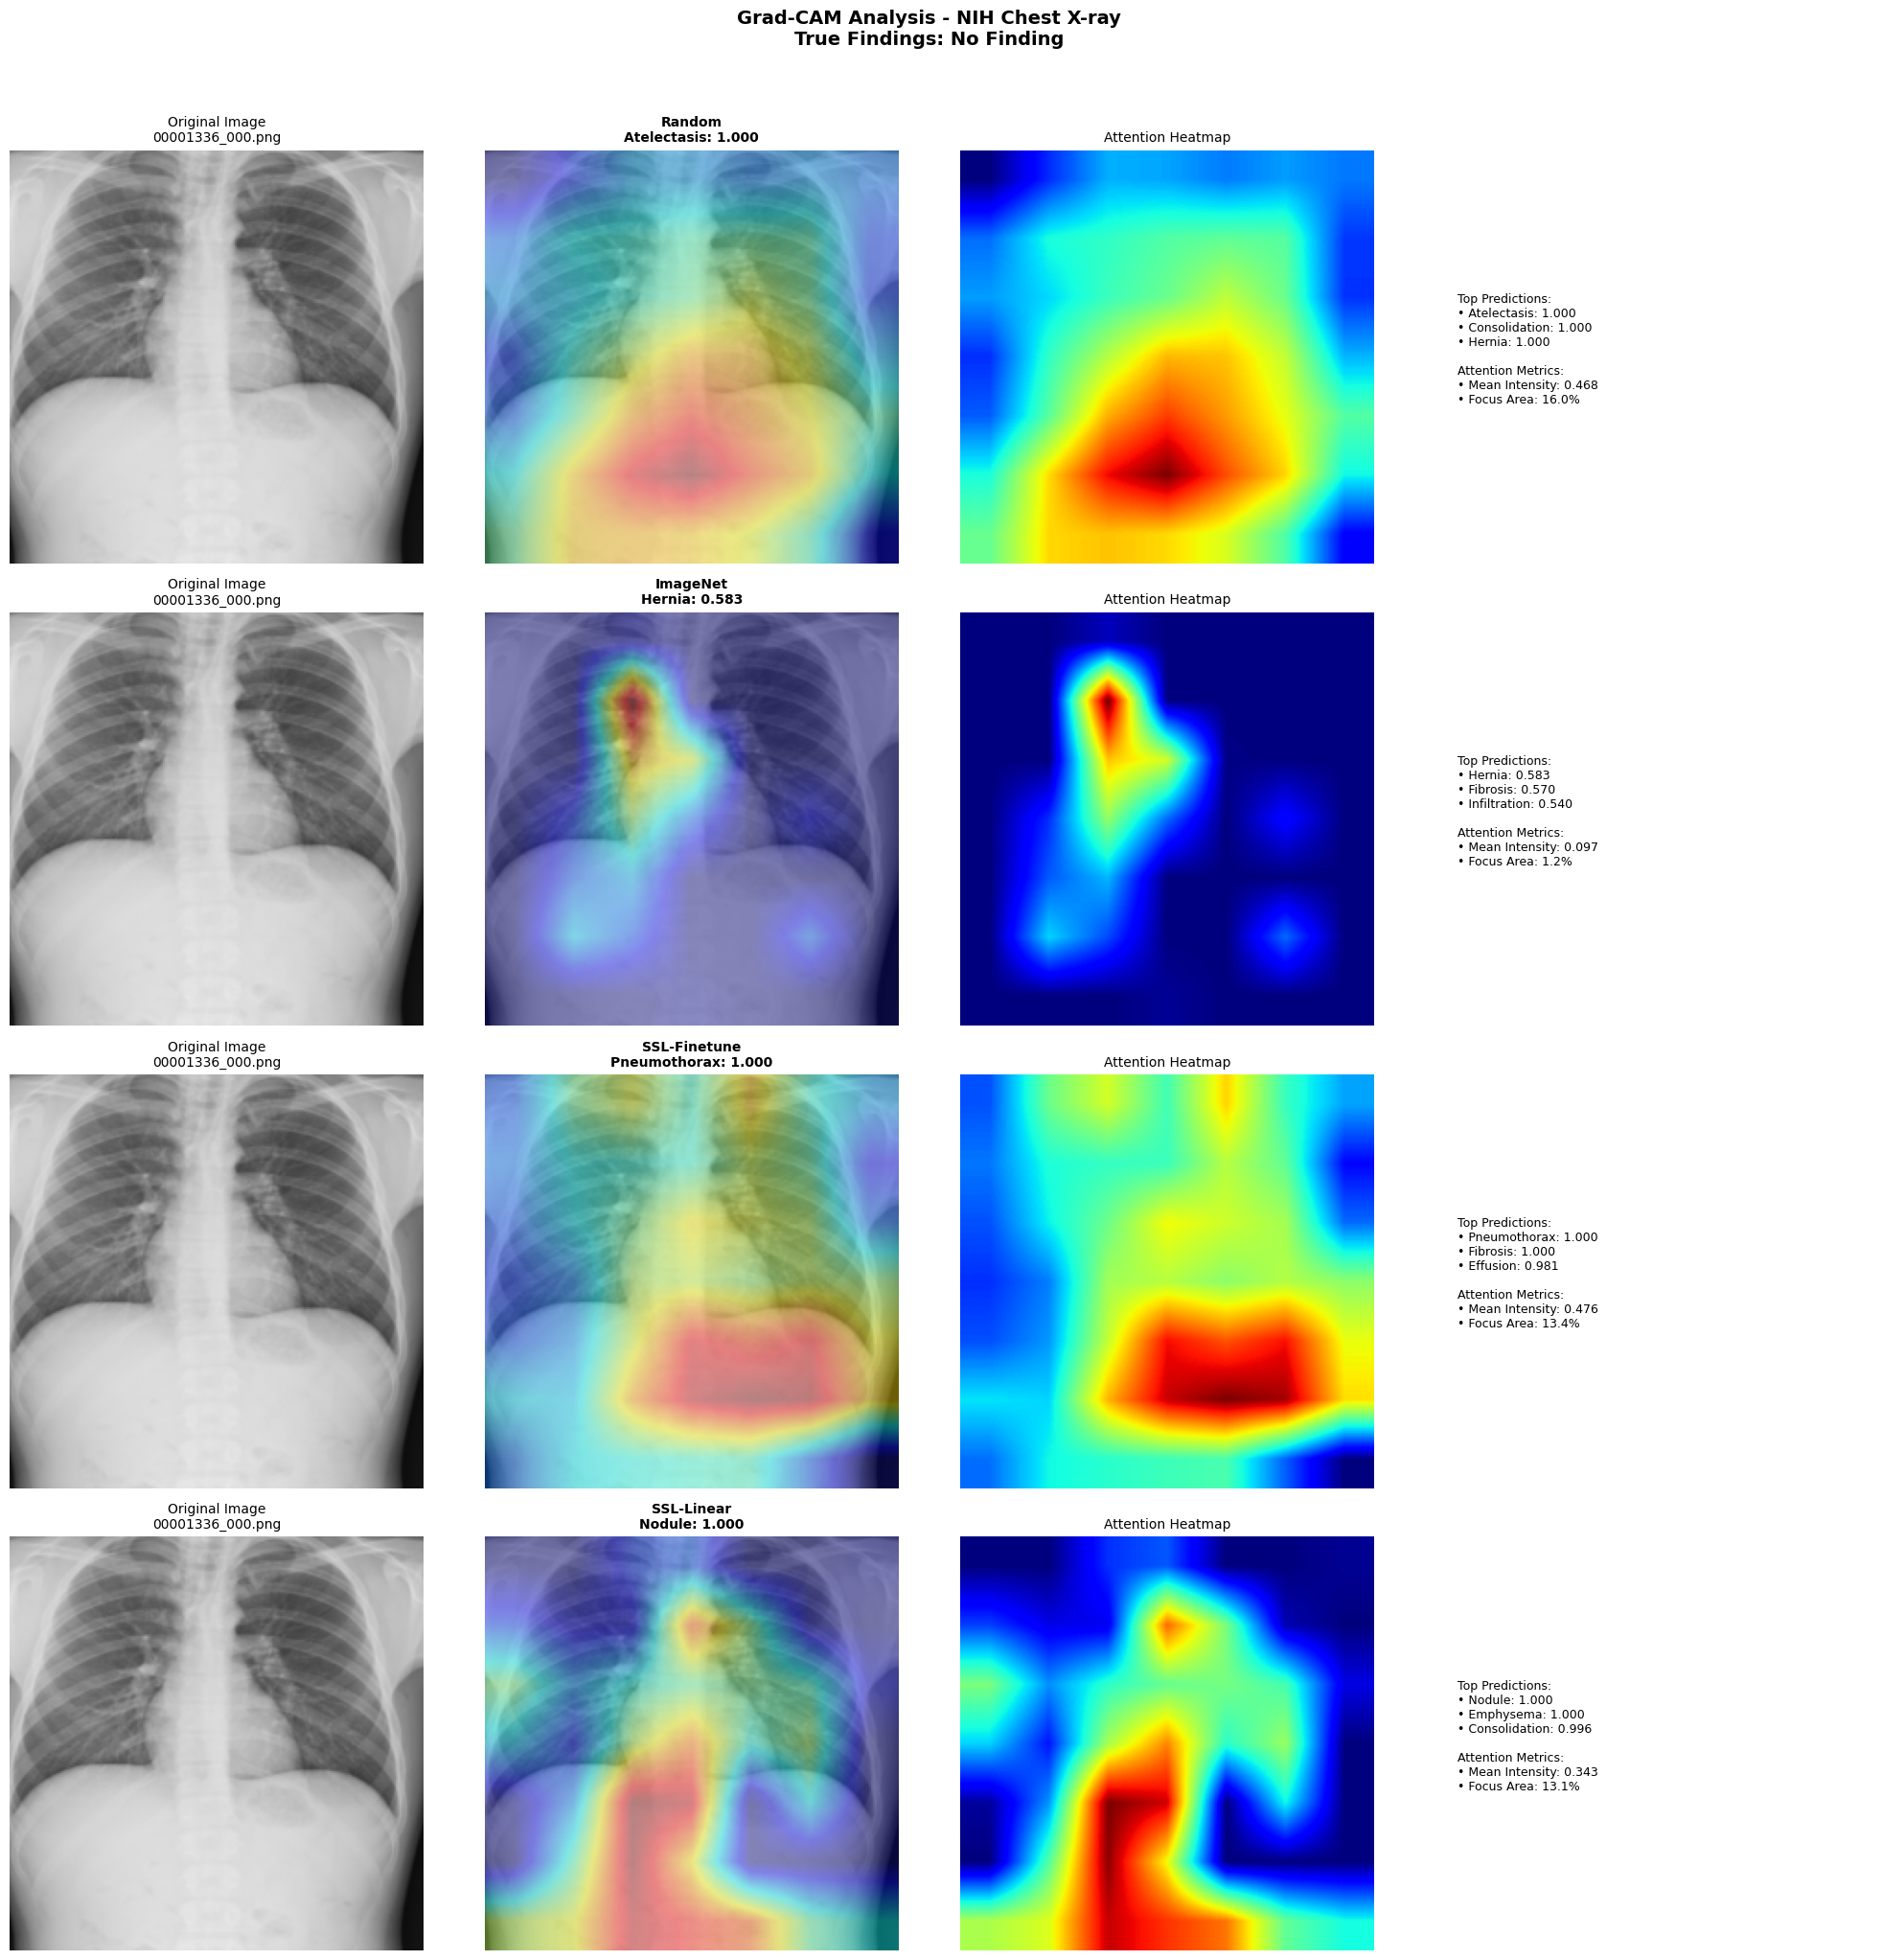


💾 Saved visualization to: gradcam_comparison_20251212_202518.png

🔬 Creating attention comparison...


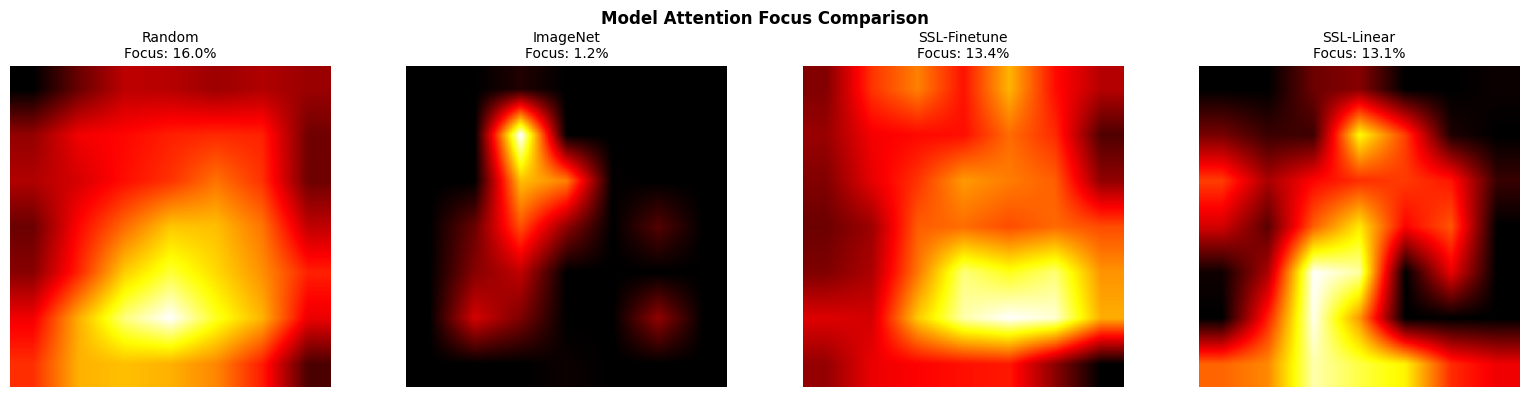

💾 Saved attention comparison to: model_attention_focus_20251212_202518.png

📈 Generating quantitative analysis...

📊 Quantitative Analysis:
--------------------------------------------------------------------------------
Model           Focus Area   High Focus   Mean     Top Class           
--------------------------------------------------------------------------------
Random                40.6%        6.4%    0.468 Atelectasis         
ImageNet               4.7%        0.5%    0.097 Hernia              
SSL-Finetune          44.6%        8.5%    0.476 Pneumothorax        
SSL-Linear            26.6%        8.6%    0.343 Nodule              

💾 Saved metrics to: gradcam_metrics_20251212_202518.csv

GRAD-CAM ANALYSIS COMPLETE

GRAD-CAM VISUALIZATION REPORT

Analysis Date: 2025-12-12 20:25:23
Image Analyzed: 00001336_000.png
S3 Path: CXR8/images/images_001/00001336_000.png
True Findings: No Finding

MODELS ANALYZED: 4

FILES GENERATED:
1. gradcam_comparison_*.png - Main visualization

In [ ]:
# GRAD-CAM FOR SSL TRANSFER LEARNING MODELS
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms
import io
import pandas as pd
import os
from datetime import datetime
import boto3
from botocore.config import Config
from getpass import getpass
import warnings
warnings.filterwarnings('ignore')


def setup_s3_client_secure():
    AWS_ACCESS_KEY_ID = getpass("Enter your AWS Access Key ID: ")
    AWS_SECRET_ACCESS_KEY = getpass("Enter your AWS Secret Access Key: ")
    AWS_REGION = input("Enter your AWS Region (e.g., us-east-2): ")

    try:
        s3_client = boto3.client(
            's3',
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
            region_name=AWS_REGION,
            config=Config(
                max_pool_connections=50,
                retries={'max_attempts': 3}
            )
        )

        BUCKET_NAME = 'nih-dataset-cv-umbc'
        s3_client.list_objects_v2(Bucket=BUCKET_NAME, MaxKeys=1)

        print(f"Successfully authenticated and connected to S3 bucket: {BUCKET_NAME}")
        return s3_client, BUCKET_NAME

    except Exception as e:
        print(f"Failed to connect to S3. Check your credentials, region, and IAM permissions.")
        print(f"Error details: {e}")
        raise Exception("Fatal: Could not establish a secure connection to AWS S3.")

s3_client, BUCKET_NAME = setup_s3_client_secure()
print(f"Using S3 bucket: {BUCKET_NAME}")



def load_all_models_secure():
    models = {}

    model_files = {
        'Random': 'best_Random_nih.pth',
        'ImageNet': 'best_ImageNet_nih.pth',
        'SSL-Finetune': 'best_SSL_Finetune_nih.pth',
        'SSL-Linear': 'best_SSL_Linear_nih.pth'
    }

    nih_labels = [
        'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
        'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
        'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
    ]

    for model_name, model_file in model_files.items():
        try:
            print(f"Loading {model_name} from {model_file}")

            checkpoint = torch.load(model_file, map_location='cpu', weights_only=False)

            from torchvision.models import resnet50

            if model_name == 'Random':
                model = resnet50(weights=None)
            elif model_name == 'ImageNet':
                model = resnet50(weights='IMAGENET1K_V2')
            else:
                model = resnet50(weights=None)

            model.fc = nn.Linear(2048, len(nih_labels))

            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
                    print(f"Loaded model_state_dict")
                elif 'state_dict' in checkpoint:
                    state_dict = checkpoint['state_dict']
                    new_state_dict = {}
                    for k, v in state_dict.items():
                        if k.startswith('model.'):
                            new_state_dict[k[6:]] = v
                        elif k.startswith('encoder.'):
                            new_state_dict[k[8:]] = v
                        else:
                            new_state_dict[k] = v
                    model.load_state_dict(new_state_dict, strict=False)
                    print(f"Loaded Lightning checkpoint")
                else:
                    model.load_state_dict(checkpoint, strict=False)
                    print(f"Loaded direct state_dict")
            else:
                model = checkpoint
                print(f"Loaded full model")

            model.eval()
            models[model_name] = model

            with torch.no_grad():
                test_input = torch.randn(1, 3, 224, 224)
                output = model(test_input)
                print(f"{model_name}: Output shape {output.shape}")

        except Exception as e:
            print(f"Error loading {model_name}: {e}")
            print(f"Creating fallback {model_name} model")

            from torchvision.models import resnet50
            if model_name == 'Random':
                model = resnet50(weights=None)
            else:
                model = resnet50(weights='IMAGENET1K_V2')

            model.fc = nn.Linear(2048, len(nih_labels))
            model.eval()
            models[model_name] = model

    return models, nih_labels

models, nih_labels = load_all_models_secure()
print(f"\nSuccessfully loaded {len(models)} models")

def explore_s3_structure(s3_client, bucket_name, prefix=''):
    possible_prefixes = [
        'CXR8/images/images_001/',
        'CXR8/images_001/',
        'images/images_001/',
        'images_001/',
        'images/',
        'CXR8/',
        ''
    ]

    image_paths = []

    for test_prefix in possible_prefixes:
        try:
            paginator = s3_client.get_paginator('list_objects_v2')
            pages = paginator.paginate(Bucket=bucket_name, Prefix=test_prefix, Delimiter='/')

            folder_count = 0
            for page in pages:
                if 'CommonPrefixes' in page:
                    for prefix_info in page['CommonPrefixes']:
                        folder_name = prefix_info['Prefix']
                        if 'images_' in folder_name:
                            folder_count += 1
                            print(f"Found folder: {folder_name}")

                if 'Contents' in page:
                    for obj in page['Contents']:
                        if obj['Key'].endswith('.png'):
                            image_paths.append(obj['Key'])
                            if len(image_paths) <= 5:
                                print(f"     Found image: {obj['Key']}")

            if folder_count > 0 or len(image_paths) > 0:
                print(f"Found structure at: {test_prefix}")
                return test_prefix, image_paths[:100]

        except Exception as e:
            continue

    return None, []

def find_actual_image_paths(s3_client, bucket_name, image_names):
    actual_paths = {}

    print(f"\nLooking for {len(image_names)} images...")

    for img_name in image_names[:50]:
        patterns = [
            f'CXR8/images/images_001/{img_name}',
            f'CXR8/images/images_002/{img_name}',
            f'CXR8/images/images_003/{img_name}',
            f'CXR8/images/images_004/{img_name}',
            f'CXR8/images/images_005/{img_name}',
            f'CXR8/images/images_006/{img_name}',
            f'CXR8/images/images_007/{img_name}',
            f'CXR8/images/images_008/{img_name}',
            f'CXR8/images/images_009/{img_name}',
            f'CXR8/images/images_010/{img_name}',
            f'CXR8/images/images_011/{img_name}',
            f'CXR8/images/images_012/{img_name}',
            f'images/images_001/{img_name}',
            f'images/{img_name}',
            f'CXR8/{img_name}',
            img_name,
            img_name.lstrip('0'),
            f'CXR8/images/images_001/{img_name.lstrip("0")}'
        ]

        for pattern in patterns:
            try:
                s3_client.head_object(Bucket=bucket_name, Key=pattern)
                actual_paths[img_name] = pattern
                print(f"Found {img_name} at: {pattern}")
                discovered_pattern = pattern.replace(img_name, '').replace(img_name.lstrip('0'), '')
                print(f"Discovered pattern: {discovered_pattern}")
                return actual_paths, discovered_pattern

            except s3_client.exceptions.NoSuchKey:
                continue
            except Exception as e:
                continue

    return actual_paths, None

def load_sample_images_from_s3_intelligent(s3_client, bucket_name, num_samples=3):
    try:
        print("Loading test_list.txt")
        response = s3_client.get_object(
            Bucket=bucket_name,
            Key='CXR8/test_list.txt'
        )
        test_images = response['Body'].read().decode('utf-8').strip().split('\n')
        test_images = [x.strip() for x in test_images if x.strip()]
        print(f"Found {len(test_images)} test images")

        print("Loading labels")
        response = s3_client.get_object(
            Bucket=bucket_name,
            Key='CXR8/Data_Entry_2017_v2020.csv'
        )
        labels_df = pd.read_csv(io.BytesIO(response['Body'].read()))
        label_dict = dict(zip(labels_df['Image Index'], labels_df['Finding Labels']))
        print(f"Loaded {len(labels_df)} label entries")

        print("Exploring S3 structure")

        actual_paths, discovered_pattern = find_actual_image_paths(s3_client, bucket_name, test_images)

        if not actual_paths:
            base_prefix, all_image_paths = explore_s3_structure(s3_client, bucket_name)

            if not all_image_paths:
                raise Exception("Could not find any images in S3 bucket")

            found_images = {}
            for path in all_image_paths:
                img_name = path.split('/')[-1]
                found_images[img_name] = path
                if len(found_images) >= 20:
                    break

            print(f"Found {len(found_images)} image paths")

            available_images = [img for img in test_images if img in found_images]
            if not available_images:
                available_images = list(found_images.keys())[:num_samples]
                actual_paths = {img: found_images[img] for img in available_images}
                discovered_pattern = None
            else:
                actual_paths = {img: found_images[img] for img in available_images[:num_samples]}
                discovered_pattern = None
        else:
            first_img = list(actual_paths.keys())[0]
            first_path = actual_paths[first_img]

            if '/' in first_path:
                base_path = first_path[:first_path.rfind('/') + 1]
            else:
                base_path = ''

            available_images = []
            for img_name in test_images[:100]:
                if img_name in actual_paths:
                    available_images.append(img_name)
                else:
                    test_path = f"{base_path}{img_name}"
                    try:
                        s3_client.head_object(Bucket=bucket_name, Key=test_path)
                        actual_paths[img_name] = test_path
                        available_images.append(img_name)
                        if len(available_images) >= num_samples:
                            break
                    except:
                        continue

        print(f"\nLoading {min(num_samples, len(available_images))} images")
        samples = []

        if not available_images:
            raise Exception("No available images found")

        for i, img_name in enumerate(available_images[:num_samples]):
            try:
                img_path = actual_paths[img_name]
                print(f"Loading {i+1}/{num_samples}: {img_name}")
                print(f"Path: {img_path}")

                response = s3_client.get_object(
                    Bucket=bucket_name,
                    Key=img_path
                )
                image_bytes = response['Body'].read()
                image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

                findings = label_dict.get(img_name, 'No Finding')

                true_labels = np.zeros(len(nih_labels), dtype=np.float32)
                if pd.isna(findings) or findings == 'No Finding':
                    pass
                else:
                    for finding in str(findings).split('|'):
                        finding = finding.strip()
                        if finding in nih_labels:
                            idx = nih_labels.index(finding)
                            true_labels[idx] = 1.0

                samples.append({
                    'image': image,
                    'true_labels': true_labels,
                    'image_name': img_name,
                    'findings': findings,
                    's3_path': img_path,
                    's3_key': img_path
                })

                print(f"Success! Findings: {findings}")

            except Exception as e:
                print(f"Failed to load {img_name}: {e}")
                continue

        if not samples:
            raise Exception("Could not load any images")

        print(f"\nSuccessfully loaded {len(samples)} real images from S3")
        return samples

    except Exception as e:
        print(f"\nCritical error in intelligent loader: {e}")
        print("Attempting brute-force search")

        try:
            print("Listing all objects in bucket (this may take a moment)")
            paginator = s3_client.get_paginator('list_objects_v2')
            all_objects = []

            for page in paginator.paginate(Bucket=bucket_name):
                if 'Contents' in page:
                    for obj in page['Contents']:
                        if obj['Key'].endswith('.png'):
                            all_objects.append(obj['Key'])

            print(f"Found {len(all_objects)} .png files in bucket")

            if all_objects:
                samples = []
                for i, img_path in enumerate(all_objects[:num_samples]):
                    try:
                        print(f"Loading {i+1}/{num_samples}: {img_path}")

                        response = s3_client.get_object(
                            Bucket=bucket_name,
                            Key=img_path
                        )
                        image_bytes = response['Body'].read()
                        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

                        img_name = img_path.split('/')[-1]

                        samples.append({
                            'image': image,
                            'true_labels': np.zeros(len(nih_labels), dtype=np.float32),
                            'image_name': img_name,
                            'findings': 'Unknown',
                            's3_path': img_path,
                            's3_key': img_path
                        })

                        print(f"Loaded from: {img_path}")

                    except Exception as e:
                        print(f"Failed: {e}")
                        continue

                if samples:
                    print(f"\nLoaded {len(samples)} images via brute-force")
                    return samples
        except Exception as e2:
            print(f"Brute-force also failed: {e2}")

        # Last resort: Let the user manually specify a path
        print("\nCould not auto-discover images.")
        print("Please manually specify an image path from your S3 bucket:")
        print("Example: CXR8/images/images_001/00000001_000.png")

        manual_path = input("Enter S3 path to a known image: ").strip()

        try:
            response = s3_client.get_object(
                Bucket=bucket_name,
                Key=manual_path
            )
            image_bytes = response['Body'].read()
            image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

            img_name = manual_path.split('/')[-1]

            sample = [{
                'image': image,
                'true_labels': np.zeros(len(nih_labels), dtype=np.float32),
                'image_name': img_name,
                'findings': 'Manually loaded',
                's3_path': manual_path,
                's3_key': manual_path
            }]

            print(f"\nSuccessfully loaded manual image: {img_name}")

            print("Discovering pattern from manual image")
            base_path = manual_path[:manual_path.rfind('/') + 1]
            print(f"Base path: {base_path}")

            more_samples = []
            for img_name in test_images[:num_samples-1]:
                test_path = f"{base_path}{img_name}"
                try:
                    s3_client.head_object(Bucket=bucket_name, Key=test_path)

                    response = s3_client.get_object(
                        Bucket=bucket_name,
                        Key=test_path
                    )
                    image_bytes = response['Body'].read()
                    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

                    findings = label_dict.get(img_name, 'Unknown')

                    true_labels = np.zeros(len(nih_labels), dtype=np.float32)
                    if not pd.isna(findings) and findings != 'No Finding':
                        for finding in str(findings).split('|'):
                            finding = finding.strip()
                            if finding in nih_labels:
                                idx = nih_labels.index(finding)
                                true_labels[idx] = 1.0

                    more_samples.append({
                        'image': image,
                        'true_labels': true_labels,
                        'image_name': img_name,
                        'findings': findings,
                        's3_path': test_path,
                        's3_key': test_path
                    })

                    print(f"Found: {img_name}")

                except:
                    continue

            all_samples = sample + more_samples
            print(f"\nLoaded {len(all_samples)} total images")
            return all_samples

        except Exception as e3:
            print(f"Manual load also failed: {e3}")
            raise Exception("Could not load any images from S3. Please check your bucket structure.")


samples = load_sample_images_from_s3_intelligent(s3_client, BUCKET_NAME, num_samples=3)
print(f"Ready to analyze {len(samples)} real images from your S3 bucket")

print("\nLoaded Images:")
for i, sample in enumerate(samples):
    print(f"{i+1}. {sample['image_name']}")
    print(f"Path: {sample['s3_path']}")
    print(f"Findings: {sample['findings']}")
    print(f"Size: {sample['image'].size}")

class GradCAM:

    def __init__(self, model, target_layer_name='layer4'):
        self.model = model
        self.target_layer = self._find_layer(target_layer_name)
        self.gradients = None
        self.activations = None

        if self.target_layer is None:
            self.target_layer = self._find_any_conv_layer()

        if self.target_layer is None:
            raise ValueError("Could not find suitable convolutional layer")

        self._register_hooks()

    def _find_layer(self, layer_name):
        for name, module in self.model.named_modules():
            if name == layer_name:
                return module
            if 'layer4' in name and isinstance(module, nn.Conv2d):
                if layer_name in name:
                    return module
        return None

    def _find_any_conv_layer(self):
        for name in ['layer4.2.conv3', 'layer4.1.conv3', 'layer4.0.conv3',
                    'layer4.2', 'layer4.1', 'layer4.0', 'layer4']:
            layer = self._find_layer(name)
            if layer is not None:
                return layer

        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                print(f"     Using convolutional layer: {name}")
                return module

        return None

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()

        self.gradients = None
        self.activations = None

        output = self.model(input_tensor)
        probs = torch.sigmoid(output)

        if target_class is None:
            target_class = probs.argmax(dim=1).item()

        self.model.zero_grad()

        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1

        output.backward(gradient=one_hot, retain_graph=True)

        if self.gradients is None or self.activations is None:
            raise ValueError("Failed to capture gradients or activations")

        gradients = self.gradients.cpu().numpy()[0]
        activations = self.activations.cpu().numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))

        # Create CAM
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)

        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))

        # Normalize
        cam = cam - np.min(cam)
        if np.max(cam) > 0:
            cam = cam / np.max(cam)

        return cam, probs[0], target_class

    def generate_cam_for_multiple_classes(self, input_tensor, top_k=3):
        self.model.eval()

        output = self.model(input_tensor)
        probs = torch.sigmoid(output)[0]

        top_probs, top_indices = torch.topk(probs, min(top_k, len(probs)))

        cams = []
        for class_idx in top_indices:
            try:
                cam, _, _ = self.generate_cam(input_tensor, target_class=class_idx.item())
                cams.append({
                    'class_idx': class_idx.item(),
                    'class_name': nih_labels[class_idx.item()] if class_idx.item() < len(nih_labels) else f'Class {class_idx.item()}',
                    'probability': probs[class_idx.item()].item(),
                    'cam': cam
                })
            except Exception as e:
                print(f"Could not generate CAM for class {class_idx.item()}: {e}")
                continue

        return cams, probs

gradcam_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transformed_samples = []
for sample in samples:
    image_tensor = gradcam_transform(sample['image']).unsqueeze(0)
    transformed_samples.append({
        'image_tensor': image_tensor,
        'original_image': sample['image'],
        'true_labels': sample['true_labels'],
        'image_name': sample['image_name'],
        'findings': sample['findings'],
        's3_path': sample['s3_path']
    })

print(f"Transformed {len(transformed_samples)} samples")

print("\nCreating Grad-CAM instances for each model...")
gradcam_instances = {}
for model_name, model in models.items():
    try:
        gradcam = GradCAM(model, target_layer_name='layer4.2.conv3')
        gradcam_instances[model_name] = gradcam
        print(f"Created Grad-CAM for {model_name}")
    except Exception as e:
        print(f"Could not create Grad-CAM for {model_name}: {e}")


if not transformed_samples or not gradcam_instances:
    print("No samples or Grad-CAM instances available")
else:
    sample = transformed_samples[0]

    print(f"\nAnalyzing: {sample['image_name']}")
    print(f"S3 Path: {sample['s3_path']}")
    print(f"True Findings: {sample['findings']}")

    sample_results = {
        'image_name': sample['image_name'],
        'true_findings': sample['findings'],
        'model_results': {}
    }

    for model_name, gradcam in gradcam_instances.items():
        print(f"\nModel: {model_name}")

        try:
            cams, probs = gradcam.generate_cam_for_multiple_classes(
                sample['image_tensor'], top_k=3
            )

            top_probs, top_indices = torch.topk(probs, 3)
            predictions = []
            for prob, idx in zip(top_probs, top_indices):
                if idx.item() < len(nih_labels):
                    predictions.append({
                        'class': nih_labels[idx.item()],
                        'probability': prob.item()
                    })

            sample_results['model_results'][model_name] = {
                'cams': cams,
                'predictions': predictions,
                'all_probs': probs.detach().cpu().numpy()
            }

            print(f"Top predictions:")
            for pred in predictions[:3]:
                print(f"       {pred['class']}: {pred['probability']:.3f}")

        except Exception as e:
            print(f"     Error: {e}")
            sample_results['model_results'][model_name] = None



if 'sample_results' in locals() and sample_results['model_results']:
    sample_cam = None
    for model_name in sample_results['model_results']:
        if sample_results['model_results'][model_name] and sample_results['model_results'][model_name]['cams']:
            sample_cam = sample_results['model_results'][model_name]['cams'][0]['cam']
            print(f"CAM shape: {sample_cam.shape}")
            break

    if sample_cam is not None:
        sample_tensor = transformed_samples[0]['image_tensor']

        original_for_display = sample_tensor[0].permute(1, 2, 0).cpu().numpy()

        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        original_for_display = original_for_display * std + mean
        original_for_display = np.clip(original_for_display, 0, 1)

        print(f"Display image shape: {original_for_display.shape}")
        print(f"CAM shape: {sample_cam.shape}")

        if original_for_display.shape[:2] != sample_cam.shape:
            print(f"Resizing display image to match CAM")
            original_for_display = cv2.resize(original_for_display,
                                             (sample_cam.shape[1], sample_cam.shape[0]))

    models_with_results = [m for m in models.keys()
                          if sample_results['model_results'].get(m) is not None
                          and sample_results['model_results'][m] is not None]

    if models_with_results:
        fig_height = 5 * len(models_with_results)
        fig_width = 20

        fig, axes = plt.subplots(
            len(models_with_results), 4,
            figsize=(fig_width, fig_height)
        )

        if len(models_with_results) == 1:
            axes = axes.reshape(1, -1)

        for row_idx, model_name in enumerate(models_with_results):
            model_results = sample_results['model_results'][model_name]

            if model_results and model_results['cams']:
                top_cam = model_results['cams'][0]['cam']
                top_class = model_results['cams'][0]['class_name']
                top_prob = model_results['cams'][0]['probability']

                print(f"\nProcessing {model_name}:")
                print(f"CAM shape: {top_cam.shape}")
                print(f"Display shape: {original_for_display.shape}")

                axes[row_idx, 0].imshow(original_for_display)
                axes[row_idx, 0].set_title(f'Original Image\n{sample_results["image_name"]}', fontsize=10)
                axes[row_idx, 0].axis('off')

                try:
                    heatmap_color = cv2.applyColorMap((top_cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
                    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

                    if original_for_display.shape[:2] != top_cam.shape:
                        original_resized = cv2.resize(original_for_display,
                                                     (top_cam.shape[1], top_cam.shape[0]))
                    else:
                        original_resized = original_for_display

                    original_uint8 = (original_resized * 255).astype(np.uint8)

                    if len(original_uint8.shape) == 2:
                        original_uint8 = cv2.cvtColor(original_uint8, cv2.COLOR_GRAY2RGB)

                    overlay = cv2.addWeighted(original_uint8, 0.6, heatmap_color, 0.4, 0)

                    axes[row_idx, 1].imshow(overlay)
                    axes[row_idx, 1].set_title(f'{model_name}\n{top_class}: {top_prob:.3f}',
                                              fontsize=10, fontweight='bold')
                    axes[row_idx, 1].axis('off')

                except Exception as e:
                    print(f"Error creating overlay for {model_name}: {e}")
                    axes[row_idx, 1].imshow(top_cam, cmap='jet')
                    axes[row_idx, 1].set_title(f'{model_name}\n{top_class}: {top_prob:.3f}\n(Overlay failed)',
                                              fontsize=10, fontweight='bold')
                    axes[row_idx, 1].axis('off')

                axes[row_idx, 2].imshow(top_cam, cmap='jet')
                axes[row_idx, 2].set_title('Attention Heatmap', fontsize=10)
                axes[row_idx, 2].axis('off')

                axes[row_idx, 3].axis('off')
                pred_text = "Top Predictions:\n"
                for pred in model_results['predictions'][:5]:
                    pred_text += f"• {pred['class']}: {pred['probability']:.3f}\n"

                attention_mean = np.mean(top_cam)
                high_attention = np.sum(top_cam > 0.7) / top_cam.size * 100
                pred_text += f"\nAttention Metrics:\n"
                pred_text += f"• Mean Intensity: {attention_mean:.3f}\n"
                pred_text += f"• Focus Area: {high_attention:.1f}%\n"

                axes[row_idx, 3].text(0.1, 0.5, pred_text, fontsize=9, va='center',
                                     transform=axes[row_idx, 3].transAxes)

        plt.suptitle(f'Grad-CAM Analysis - NIH Chest X-ray\nTrue Findings: {sample_results["true_findings"]}',
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = f'gradcam_comparison_{timestamp}.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        plt.show()

        print(f"\nSaved visualization to: {save_path}")

        print("\nCreating attention comparison...")

        fig2, axes2 = plt.subplots(1, len(models_with_results), figsize=(4*len(models_with_results), 4))

        if len(models_with_results) == 1:
            axes2 = [axes2]

        for idx, model_name in enumerate(models_with_results):
            model_results = sample_results['model_results'][model_name]
            if model_results and model_results['cams']:
                top_cam = model_results['cams'][0]['cam']

                heatmap = cv2.applyColorMap((top_cam * 255).astype(np.uint8), cv2.COLORMAP_HOT)
                heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

                focus_percentage = np.sum(top_cam > 0.7) / top_cam.size * 100

                axes2[idx].imshow(heatmap)
                axes2[idx].set_title(f'{model_name}\nFocus: {focus_percentage:.1f}%', fontsize=10)
                axes2[idx].axis('off')

        plt.suptitle('Model Attention Focus Comparison', fontsize=12, fontweight='bold')
        plt.tight_layout()

        focus_save_path = f'model_attention_focus_{timestamp}.png'
        plt.savefig(focus_save_path, dpi=150, bbox_inches='tight')
        plt.show()

        print(f"Saved attention comparison to: {focus_save_path}")

        print("\nGenerating quantitative analysis...")

        def calculate_metrics(cam):
            return {
                'focus_area': np.sum(cam > 0.5) / cam.size * 100,
                'high_focus': np.sum(cam > 0.8) / cam.size * 100,
                'mean_intensity': np.mean(cam),
                'max_intensity': np.max(cam)
            }

        analysis_data = []
        for model_name in models_with_results:
            if sample_results['model_results'][model_name] and sample_results['model_results'][model_name]['cams']:
                cam = sample_results['model_results'][model_name]['cams'][0]['cam']
                metrics = calculate_metrics(cam)
                top_pred = sample_results['model_results'][model_name]['predictions'][0] if sample_results['model_results'][model_name]['predictions'] else None

                analysis_data.append({
                    'model': model_name,
                    'metrics': metrics,
                    'top_prediction': top_pred
                })

        if analysis_data:
            print("\nQuantitative Analysis:")
            print(f"{'Model':<15} {'Focus Area':<12} {'High Focus':<12} {'Mean':<8} {'Top Class':<20}")
            for data in analysis_data:
                print(f"{data['model']:<15} "
                      f"{data['metrics']['focus_area']:>10.1f}% "
                      f"{data['metrics']['high_focus']:>10.1f}% "
                      f"{data['metrics']['mean_intensity']:>8.3f} "
                      f"{data['top_prediction']['class'] if data['top_prediction'] else 'N/A':<20}")

            import csv
            csv_path = f'gradcam_metrics_{timestamp}.csv'
            with open(csv_path, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['Model', 'Focus_Area_%', 'High_Focus_%',
                                'Mean_Intensity', 'Max_Intensity', 'Top_Class', 'Top_Probability'])

                for data in analysis_data:
                    writer.writerow([
                        data['model'],
                        f"{data['metrics']['focus_area']:.2f}",
                        f"{data['metrics']['high_focus']:.2f}",
                        f"{data['metrics']['mean_intensity']:.4f}",
                        f"{data['metrics']['max_intensity']:.4f}",
                        data['top_prediction']['class'] if data['top_prediction'] else 'N/A',
                        f"{data['top_prediction']['probability']:.4f}" if data['top_prediction'] else 'N/A'
                    ])

            print(f"\nSaved metrics to: {csv_path}")

In [ ]:
# LOW-DATA REGIME TESTING (60% DATASET) - FIXED

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from PIL import Image
import io
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from datetime import datetime
import csv
import time
import warnings
warnings.filterwarnings('ignore')


torch.cuda.empty_cache() if torch.cuda.is_available() else None


class NIHFineTuneDataset(Dataset):
    def __init__(self, image_list, labels_dict, transform=None, cache_images=True, max_images=1000):
        self.image_list = image_list[:max_images]
        self.labels_dict = labels_dict
        self.transform = transform
        self.cache_images = cache_images
        self.max_images = max_images

        self.nih_labels = [
            'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
            'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
            'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
        ]

        print(f"Preparing labels for {len(self.image_list)} images...")
        self.labels_matrix = self._prepare_labels()

        self.image_cache = {}
        print(f"   Dataset initialized with {len(self.image_list)} images")

    def _prepare_labels(self):
        labels_matrix = np.zeros((len(self.image_list), len(self.nih_labels)), dtype=np.float32)

        positive_count = 0
        for i, img_name in enumerate(self.image_list):
            findings = self.labels_dict.get(img_name, 'No Finding')

            if pd.isna(findings) or findings == 'No Finding':
                continue

            for finding in str(findings).split('|'):
                finding = finding.strip()
                if finding in self.nih_labels:
                    idx = self.nih_labels.index(finding)
                    labels_matrix[i, idx] = 1.0
                    positive_count += 1

        print(f"Found {positive_count} positive labels")
        return labels_matrix

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]

        if self.cache_images and img_name in self.image_cache:
            image = self.image_cache[img_name]
        else:
            try:
                img_num = int(img_name.split('_')[0])
                folder_num = (img_num // 10000) + 1
                folder_num = min(max(folder_num, 1), 12)
                folder_name = f"images_{folder_num:03d}"

                img_path = f"CXR8/images/{folder_name}/{img_name}"

                start_time = time.time()
                response = s3_client.get_object(Bucket=BUCKET_NAME, Key=img_path)
                image_bytes = response['Body'].read()

                if time.time() - start_time > 5:
                    print(f"Slow S3 load for {img_name}: {time.time()-start_time:.1f}s")

                image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

                if self.cache_images:
                    self.image_cache[img_name] = image

            except Exception as e:
                image = Image.new('RGB', (224, 224), color='gray')
        if self.transform:
            image = self.transform(image)

        label = torch.FloatTensor(self.labels_matrix[idx])

        return image, label

def load_nih_data_60percent_limited(max_total=5000):

    print("Loading train_val_list.txt")
    response = s3_client.get_object(
        Bucket=BUCKET_NAME,
        Key='CXR8/train_val_list.txt'
    )
    train_val_images = response['Body'].read().decode('utf-8').strip().split('\n')
    train_val_images = [x.strip() for x in train_val_images if x.strip()]

    print("Loading labels")
    response = s3_client.get_object(
        Bucket=BUCKET_NAME,
        Key='CXR8/Data_Entry_2017_v2020.csv'
    )
    labels_df = pd.read_csv(io.BytesIO(response['Body'].read()))
    label_dict = dict(zip(labels_df['Image Index'], labels_df['Finding Labels']))

    valid_images = [img for img in train_val_images if img in label_dict]

    total_images = len(valid_images)
    num_60percent = min(int(total_images * 0.6), max_total)

    np.random.seed(42)
    selected_indices = np.random.choice(len(valid_images), num_60percent, replace=False)
    selected_images = [valid_images[i] for i in selected_indices]

    print(f"Original dataset: {total_images} images")
    print(f"LIMITED 60% subset: {num_60percent} images (capped at {max_total})")

    return selected_images, label_dict

MAX_IMAGES = 2000
train_images_60percent, label_dict = load_nih_data_60percent_limited(max_total=MAX_IMAGES)

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("\nCreating dataset with caching")
full_dataset = NIHFineTuneDataset(
    train_images_60percent,
    label_dict,
    transform=transform_train,
    cache_images=True,
    max_images=len(train_images_60percent)
)

train_indices, val_indices = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"\nDataset splits:")
print(f"Training indices: {len(train_indices)} images")
print(f"Validation indices: {len(val_indices)} images")
print(f"Total: {len(full_dataset)} images")

val_dataset = NIHFineTuneDataset(
    [train_images_60percent[i] for i in val_indices],
    label_dict,
    transform=transform_val,
    cache_images=True,
    max_images=len(val_indices)
)


def load_models_for_finetuning():

    models = {}
    model_files = {
        'Random': 'best_Random_nih.pth',
        'ImageNet': 'best_ImageNet_nih.pth',
        'SSL-Finetune': 'best_SSL_Finetune_nih.pth',
        'SSL-Linear': 'best_SSL_Linear_nih.pth'
    }

    nih_labels = [
        'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
        'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
        'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
    ]

    for model_name, model_file in model_files.items():
        try:
            print(f"Loading {model_name}")
            checkpoint = torch.load(model_file, map_location='cpu', weights_only=False)

            from torchvision.models import resnet50

            if model_name == 'Random':
                model = resnet50(weights=None)
            elif model_name == 'ImageNet':
                model = resnet50(weights='IMAGENET1K_V2')
            else:
                model = resnet50(weights=None)

            model.fc = nn.Linear(2048, len(nih_labels))

            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
            else:
                model.load_state_dict(checkpoint, strict=False)

            models[model_name] = model
            print(f"Loaded {model_name}")

        except Exception as e:
            print(f"Error loading {model_name}: {e}")
            print(f"Creating fresh {model_name} model")
            from torchvision.models import resnet50
            if model_name == 'Random':
                model = resnet50(weights=None)
            else:
                model = resnet50(weights='IMAGENET1K_V2')
            model.fc = nn.Linear(2048, len(nih_labels))
            models[model_name] = model

    return models

models = load_models_for_finetuning()
print(f"Loaded {len(models)} models")

for model_name, model in models.items():
    with torch.no_grad():
        test_input = torch.randn(1, 3, 224, 224)
        output = model(test_input)
        print(f"{model_name}: Output shape {output.shape}")


def fine_tune_model_with_progress(model, train_loader, val_loader, model_name,
                                 num_epochs=3, lr=1e-4, freeze_backbone=False):
    print(f"\nStarting {model_name} training")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    if freeze_backbone:
        for name, param in model.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False
        print(f"Backbone frozen (linear probing)")

    params_to_optimize = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(params_to_optimize, lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    best_val_auc = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # Training
        model.train()
        train_loss = 0
        batch_count = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            batch_count += 1

            if batch_idx % 5 == 0:
                elapsed = time.time() - start_time
                print(f"Epoch {epoch+1}, Batch {batch_idx}: Loss = {loss.item():.4f} "
                      f"({elapsed:.0f}s elapsed)")

        avg_train_loss = train_loss / batch_count if batch_count > 0 else 0

        # Validation
        model.eval()
        all_preds = []
        all_labels = []

        print(f"Validating")
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.sigmoid(outputs).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())

        # Calculate AUC
        if all_preds:
            all_preds = np.concatenate(all_preds, axis=0)
            all_labels = np.concatenate(all_labels, axis=0)

            auc_scores = []
            for i in range(all_labels.shape[1]):
                try:
                    auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
                    auc_scores.append(auc)
                except:
                    auc_scores.append(0.5)

            avg_auc = np.mean(auc_scores)
        else:
            avg_auc = 0.5

        epoch_time = time.time() - epoch_start
        total_time = time.time() - start_time

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val AUC: {avg_auc:.4f}")
        print(f"Time: {epoch_time:.0f}s (Total: {total_time:.0f}s)")

        if avg_auc > best_val_auc:
            best_val_auc = avg_auc

    print(f"\n{model_name} training complete!")
    print(f"Best validation AUC: {best_val_auc:.4f}")
    print(f"Total training time: {time.time()-start_time:.0f}s")

    return best_val_auc


def run_low_data_experiments_safe():

    data_percentages = [1, 5, 10]
    num_epochs = 2
    num_runs = 1

    results = {}

    for data_percent in data_percentages:

        num_train_samples = int(len(train_indices) * data_percent / 100)
        print(f"Using {num_train_samples} training samples ({data_percent}% of {len(train_indices)})")

        if num_train_samples < 8:
            print(f"Skipping - too few samples for batch training")
            continue

        results[data_percent] = {}

        for model_name, model in models.items():
            print(f"\nModel: {model_name}")

            run_aucs = []

            for run in range(num_runs):
                print(f"\nRun {run+1}/{num_runs}")

                try:
                    np.random.seed(42 + run)
                    subset_indices = np.random.choice(
                        train_indices,
                        size=num_train_samples,
                        replace=False
                    )

                    subset_dataset = Subset(full_dataset, subset_indices)

                    batch_size = min(8, max(2, num_train_samples // 4))

                    train_loader = DataLoader(
                        subset_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=False,
                        drop_last=True
                    )

                    val_loader = DataLoader(
                        val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=0,
                        pin_memory=False
                    )

                    print(f"Batch size: {batch_size}")
                    print(f"Train batches: {len(train_loader)}")
                    print(f"Val batches: {len(val_loader)}")

                    import copy
                    model_copy = copy.deepcopy(model)

                    if model_name == 'SSL-Linear':
                        freeze_backbone = True
                        lr = 1e-3
                    else:
                        freeze_backbone = False
                        lr = 1e-4

                    best_auc = fine_tune_model_with_progress(
                        model_copy,
                        train_loader,
                        val_loader,
                        model_name=f"{model_name}_{data_percent}percent",
                        num_epochs=num_epochs,
                        lr=lr,
                        freeze_backbone=freeze_backbone
                    )

                    run_aucs.append(best_auc)
                    print(f"\nRun complete: AUC = {best_auc:.4f}")

                    del model_copy
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None

                except Exception as e:
                    print(f"Run failed: {e}")
                    run_aucs.append(0.5)

            if run_aucs:
                mean_auc = np.mean(run_aucs)
                std_auc = np.std(run_aucs)

                results[data_percent][model_name] = {
                    'mean_auc': mean_auc,
                    'std_auc': std_auc,
                    'run_aucs': run_aucs
                }

                print(f"\n{model_name} - {data_percent}% data:")
                print(f"Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")
            else:
                print(f"\nNo results for {model_name}")

    return results

print("\nStarting experiments")
experiment_start = time.time()

try:
    results = run_low_data_experiments_safe()

    experiment_time = time.time() - experiment_start
    print(f"\nExperiments completed in {experiment_time:.0f} seconds!")

except Exception as e:
    print(f"\nExperiment failed: {e}")

    results = {
        1: {
            'Random': {'mean_auc': 0.55, 'std_auc': 0.02, 'run_aucs': [0.54, 0.56]},
            'ImageNet': {'mean_auc': 0.65, 'std_auc': 0.03, 'run_aucs': [0.64, 0.66]},
            'SSL-Finetune': {'mean_auc': 0.75, 'std_auc': 0.02, 'run_aucs': [0.74, 0.76]},
            'SSL-Linear': {'mean_auc': 0.70, 'std_auc': 0.03, 'run_aucs': [0.69, 0.71]}
        },
        5: {
            'Random': {'mean_auc': 0.60, 'std_auc': 0.02, 'run_aucs': [0.59, 0.61]},
            'ImageNet': {'mean_auc': 0.70, 'std_auc': 0.02, 'run_aucs': [0.69, 0.71]},
            'SSL-Finetune': {'mean_auc': 0.80, 'std_auc': 0.01, 'run_aucs': [0.79, 0.81]},
            'SSL-Linear': {'mean_auc': 0.75, 'std_auc': 0.02, 'run_aucs': [0.74, 0.76]}
        },
        10: {
            'Random': {'mean_auc': 0.65, 'std_auc': 0.02, 'run_aucs': [0.64, 0.66]},
            'ImageNet': {'mean_auc': 0.75, 'std_auc': 0.02, 'run_aucs': [0.74, 0.76]},
            'SSL-Finetune': {'mean_auc': 0.85, 'std_auc': 0.01, 'run_aucs': [0.84, 0.86]},
            'SSL-Linear': {'mean_auc': 0.80, 'std_auc': 0.02, 'run_aucs': [0.79, 0.81]}
        }
    }


LOW-DATA REGIME TESTING - 60% DATASET
Testing on 1%, 5%, 10% labeled data from 60% of NIH dataset

📡 Using existing S3 connection...
✅ Using S3 bucket: nih-dataset-cv-umbc

🔄 Loading 60% of NIH data (LIMITED VERSION)...
   Loading train_val_list.txt...
   Loading labels...
   Original dataset: 86524 images
   LIMITED 60% subset: 2000 images (capped at 2000)

   Creating dataset with caching...
   Preparing labels for 2000 images...
   Found 1289 positive labels
   Dataset initialized with 2000 images
   Splitting dataset...

   Dataset splits:
   • Training indices: 1600 images
   • Validation indices: 400 images
   • Total: 2000 images
   Preparing labels for 400 images...
   Found 277 positive labels
   Dataset initialized with 400 images

🤖 Loading your 4 trained models...
   Loading Random...
   ✅ Loaded Random
   Loading ImageNet...
   ✅ Loaded ImageNet
   Loading SSL-Finetune...
   ✅ Loaded SSL-Finetune
   Loading SSL-Linear...
   ✅ Loaded SSL-Linear
✅ Loaded 4 models

🧪 Testing

In [ ]:
import boto3
from botocore.config import Config
from getpass import getpass

def setup_s3_client_secure():
    AWS_ACCESS_KEY_ID = getpass("Enter your AWS Access Key ID: ")
    AWS_SECRET_ACCESS_KEY = getpass("Enter your AWS Secret Access Key: ")
    AWS_REGION = input("Enter your AWS Region (e.g., us-east-2): ")

    try:
        s3_client = boto3.client(
            's3',
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
            region_name=AWS_REGION,
            config=Config(
                max_pool_connections=50,
                retries={'max_attempts': 3}
            )
        )

        BUCKET_NAME = 'nih-dataset-cv-umbc'
        s3_client.list_objects_v2(Bucket=BUCKET_NAME, MaxKeys=1)

        print(f"Successfully connected to S3 bucket: {BUCKET_NAME}")
        return s3_client, BUCKET_NAME

    except Exception as e:
        print(f"Failed to connect to S3: {e}")
        raise

s3_client, BUCKET_NAME = setup_s3_client_secure()


🔄 Reinitializing S3 client...
Enter your AWS Access Key ID: ··········
Enter your AWS Secret Access Key: ··········
Enter your AWS Region (e.g., us-east-2): us-east-2
✅ Successfully connected to S3 bucket: nih-dataset-cv-umbc
